# Module 5: Feature Engineering and Machine Learning

## Part 1 - Data Preparation

### 1. Load the data set and run the Logistic Regression (LGR) model

In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
from typing import Tuple
from IPython.display import display
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# ignoring the annoying warning messages (e.g., from LGR model)
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [2]:
def accuracy_tracker():
    """
    Generator function to track accuracy scores for different models
    """
    # Initialize an empty dataframe to store the results
    results = pd.DataFrame(columns=["Model Name", "Accuracy Score"])
    
    while True:

        # Receive a tuple with the model name and accuracy score
        model_name, accuracy = (yield)
        
        # Append the received data to the results dataframe
        new_result = pd.DataFrame({
            "Model Name": [model_name],
            "Accuracy Score": [accuracy]
        })
        results = pd.concat([results, new_result], ignore_index=True)
        display(results)

# Initialize the generator function
tracker = accuracy_tracker()

# Prime the generator function to start tracking accuracy scores
next(tracker)

In [3]:
# Load the dataset into a pandas dataframe
df = pd.read_csv('winequality-red.csv')

def LGR(data: pd.DataFrame, target: str = 'quality') -> Tuple[float, pd.DataFrame]:
    """
    Logistic Regression Model (LGR) function to 
    - split data into features and target (`quality`)
    - train LGR classifier
    - make predictions on the test set
    - return accuracy score (float) and feature weights (dataframe)
    """
    # Split the dataset into features and target
    X = data.drop(target, axis=1)
    y = data[target]

    #convert y values to categorical values
    y_transformed = LabelEncoder().fit_transform(y)

    # Split the dataset into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y_transformed, test_size=0.2, random_state=0)

    # Train a logistic regression classifier on the training data
    clf = LogisticRegression(solver='lbfgs', max_iter=1000)
    clf.fit(X_train, y_train)

    # ----- ACCURACY SCORE -----
    # Make predictions on the test data
    y_pred = clf.predict(X_test)
    # Assess the accuracy
    acc = accuracy_score(y_test, y_pred)

    # ----- FEATURE WEIGHTS -----
    # Get the feature coefs (importance)
    coefs = clf.coef_[0]
    # Get the column names of the features
    features = X.columns
    # Combine the feature names and coefficients into a DataFrame
    df_coefs = pd.DataFrame({'Feature': features, 'Coef': coefs})
    # Create a new column based on the abs. val. of the coefs (i.e., ignoring directionality)
    df_coefs['Magnitude'] = abs(df_coefs['Coef'])
    # Sort the DataFrame by magnitudes
    df_weights = df_coefs.sort_values(by='Magnitude', ascending=False)

    # Return the accuracy score and feature weights
    return acc, df_weights

acc, _ = LGR(df)
tracker.send(("Model 1: Default Data (LGR)", acc))

,Model Name,Accuracy Score
0,Model 1: Default Data (LGR),0.61875


An accuracy score of 0.61875 is relatively low; the logistic regression classifier does not perform well on the unprocessed wine quality dataset. It may be necessary to process the data further such as by normalizing the features, imputing missing values, or removing outliers.

### 2. Explore and sanitize the data

In [4]:
def describe_more(data: pd.DataFrame) -> pd.DataFrame:
    """
    Helper function that returns extended descriptive statistics on missingness for a Pandas data frame
    """
    
    # Get basic descriptive statistics for the data using the describe() method
    describe = data.describe().T
    
    # Drop the 25%, 50%, and 75% quantiles from the basic statistics
    less = describe.drop(columns=['25%', '50%', '75%'])
    
    # Add the number and percentage of missing values, and the data type for each column
    more = less.assign(num_missing = data.isna().sum(),
                       perc_missing = round(data.isna().mean() * 100, 2),
                       dtype = data.dtypes)
    
    return more

# Apply the describe_more function to the wine quality data set
describe_more(df)

,count,mean,std,min,max,num_missing,perc_missing,dtype
fixed acidity,1599.0,8.319637,1.741096,4.60000,15.90000,0,0.0,float64
volatile acidity,1599.0,0.527821,0.179060,0.12000,1.58000,0,0.0,float64
citric acid,1599.0,0.270976,0.194801,0.00000,1.00000,0,0.0,float64
residual sugar,1599.0,2.538806,1.409928,0.90000,15.50000,0,0.0,float64
chlorides,1599.0,0.087467,0.047065,0.01200,0.61100,0,0.0,float64
free sulfur dioxide,1599.0,15.874922,10.460157,1.00000,72.00000,0,0.0,float64
total sulfur dioxide,1599.0,46.467792,32.895324,6.00000,289.00000,0,0.0,float64
density,1599.0,0.996747,0.001887,0.99007,1.00369,0,0.0,float64
pH,1599.0,3.311113,0.154386,2.74000,4.01000,0,0.0,float64
sulphates,1599.0,0.658149,0.169507,0.33000,2.00000,0,0.0,float64


In [5]:
# Plot a box plot of the unedited dataset using Plotly Express
fig = px.box(df, boxmode='group', orientation='h')
fig.show()

Several features in the wine quality dataset have a large number of outliers and are not normally distributed, including `total sulfur dioxide`, `free sulfur dioxide`, `residual sugar`, and `fixed acidity`. Although these outliers may represent genuine values in the context of red wines, they can greatly influence the predictive capabilities of models and result in overfitting or underfitting. To address this, I will remove the outlier values by trimming them. Winsorizing, where outliers are imputed to reduce their impact, is another method to consider in the future.

In [6]:
def trim_outliers(data: pd.Series, factor: float=1.5) -> pd.Series:
    """
    Helper function to trim outliers from a panda series using the Tukey method
    """
    
    # Calculate the first (Q1) and third (Q3) quartiles of the data
    Q1, Q3 = np.percentile(data, 25), np.percentile(data, 75)
    
    # Calculate the interquartile range (IQR)
    IQR = Q3 - Q1
    
    # Calculate the lower and upper fences using the factor and IQR
    lower_fence, upper_fence = (Q1 - factor * IQR), (Q3 + factor * IQR)
    
    # Return the data that falls within the lower and upper fences
    return data[(data >= lower_fence) & (data <= upper_fence)]

# Trim outliers from each column (except `quality`) of the data set using the trim_outliers function
df_trimmed = df.drop("quality", axis=1).apply(lambda x: trim_outliers(x))
df_trimmed["quality"] = df["quality"]

Trimming the data results in missing values as the outliers for each feature are forcibly removed.

In [7]:
# Describe the trimmed data and sort the result by percentage of missing values in descending order
describe_more(df_trimmed).sort_values(by='perc_missing', ascending=False)

,count,mean,std,min,max,num_missing,perc_missing,dtype
residual sugar,1444.0,2.179848,0.449141,0.90000,3.650,155,9.69,float64
chlorides,1487.0,0.078756,0.014865,0.04100,0.119,112,7.00,float64
sulphates,1540.0,0.636416,0.120963,0.33000,0.990,59,3.69,float64
total sulfur dioxide,1544.0,42.997409,27.214797,6.00000,122.000,55,3.44,float64
fixed acidity,1550.0,8.162581,1.513582,4.60000,12.300,49,3.06,float64
density,1554.0,0.996735,0.001667,0.99235,1.001,45,2.81,float64
pH,1564.0,3.308772,0.140498,2.93000,3.680,35,2.19,float64
free sulfur dioxide,1569.0,15.186106,9.226586,1.00000,42.000,30,1.88,float64
volatile acidity,1580.0,0.520554,0.166581,0.12000,1.010,19,1.19,float64
alcohol,1586.0,10.394378,1.021412,8.40000,13.500,13,0.81,float64


Most machine learning models do not handle missing data well. There are several common approaches to addressing missing values:

- Dropping rows, which is typically suitable when the number of missing values is less than or equal to 2-3% of the total number of rows
- Imputing missing data by replacing it with the mean, median, or mode value of the column
- Predicting missing data using statistical or machine learning models, which is considered a more sophisticated and accurate approach.

For this dataset, I will use Sklearn's experimental `IterativeImputer`, which is a predictive method for handling missing data.

In [8]:
# Create an IterativeImputer object with a maximum of 10 iterations and a random state of 0
imputer = IterativeImputer(max_iter=10, random_state=0)

# Fit the imputer to the trimmed data and transform the data to impute missing values
df_imputed = imputer.fit_transform(df_trimmed)

# Convert the imputed data to a Pandas data frame with the same column names as the trimmed data
df_imputed = pd.DataFrame(df_imputed, columns=df_trimmed.columns)

# Describe the imputed data --> no more missing values!
describe_more(df_imputed)

,count,mean,std,min,max,num_missing,perc_missing,dtype
fixed acidity,1599.0,8.257952,1.590098,4.600000,12.300,0,0.0,float64
volatile acidity,1599.0,0.522153,0.166547,0.120000,1.010,0,0.0,float64
citric acid,1599.0,0.270556,0.193951,0.000000,0.790,0,0.0,float64
residual sugar,1599.0,2.216028,0.451229,0.900000,3.650,0,0.0,float64
chlorides,1599.0,0.078956,0.014481,0.041000,0.119,0,0.0,float64
free sulfur dioxide,1599.0,15.346518,9.230855,1.000000,42.000,0,0.0,float64
total sulfur dioxide,1599.0,44.171930,27.594177,6.000000,122.000,0,0.0,float64
density,1599.0,0.996714,0.001724,0.991252,1.001,0,0.0,float64
pH,1599.0,3.310675,0.142577,2.930000,3.680,0,0.0,float64
sulphates,1599.0,0.635833,0.119615,0.330000,0.990,0,0.0,float64


In [9]:
# Plot a box plot of the imputed data using Plotly Express --> looking much better than before!
fig = px.box(df_imputed, boxmode='group', orientation='h')
fig.show()

### 3. Examine pair-wise correlations between all features and the target

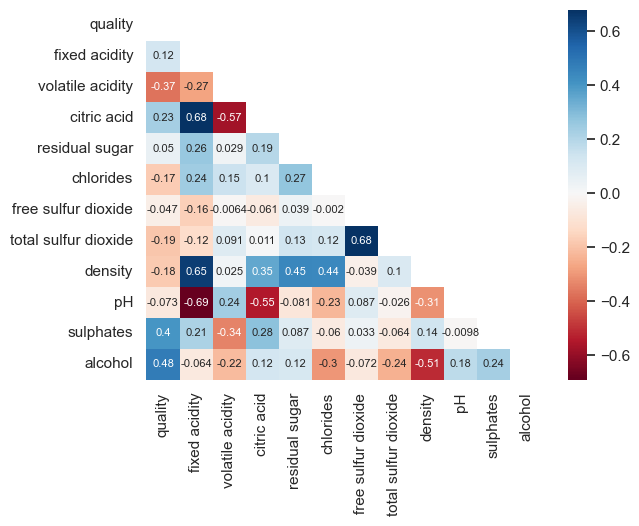

In [10]:
def move_last_to_first(data: pd.DataFrame) -> pd.DataFrame:
    """
    Helper function to re-order last column to first position in a dataframe
    """
    # Get the list of column names and move the last column to the front of the list
    cols = data.columns.tolist()
    cols = cols[-1:] + cols[:-1]

    # Return the re-ordered columns in the dataframe using the new order of column names
    return data[cols]

df_imputed = move_last_to_first(df_imputed)

sns.set_theme(style="white")

# Compute the pairwise correlations between features in the dataframe
corr = df_imputed.corr()

# Mask the lower triangle of the correlation matrix to exclude redundant values
mask = np.triu(np.ones_like(corr, dtype=bool))

# Plot the correlation matrix heatmap
sns.heatmap(corr, annot=True, mask=mask, cmap='RdBu', center=0, annot_kws={"size": 8})

# Show the plot
plt.show()

Features most correlated with the target variable include `alchohol` (+0.48), `sulphates` (+0.40), and `volatile acidity` (-0.37).

## Part 2 - Initial Model Run, Feature Engineering, and Model Parameter Tuning

### 4. Running the Logistic Regression (LGR) model on sanitized data

In [11]:
acc, _ = LGR(df_imputed)
tracker.send(("Model 2: Sanitized Data (LGR)", acc))

,Model Name,Accuracy Score
0,Model 1: Default Data (LGR),0.61875
1,Model 2: Sanitized Data (LGR),0.65625


### 5. Feature Engineering

As each feature corresponds with a different scale, it is necessary to normalize features so they fall within the same range.

Scikit-learn docs state that `StandardScaler` "might behave badly if the individual features do not more or less look like standard normally distributed data." The histograms below reveal that several features are non-normally distributed.

On the other hand, `MinMaxScale` will preserve the shape of the data while transforming values between 0 and 1. I am opting for this latter approach as it should perform better than `StandardScaler` for non-normally distributed features. That said, it should be noted that both `StandardScaler` and `MinMaxScaler` are very sensitive to the presence of outliers.

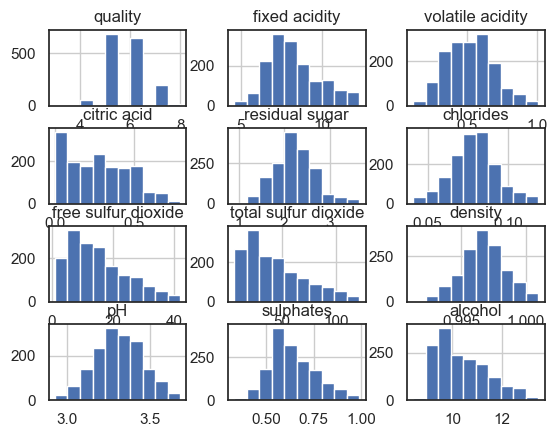

In [12]:
df_imputed.hist();

In [13]:
# Initialize MinMaxScaler
scaler = MinMaxScaler()

# Fit and transform the imputed dataset with MinMaxScaler
df_normalized = scaler.fit_transform(df_imputed)

# Convert normalized data back into a pandas dataframe with original column names
df_normalized = pd.DataFrame(df_normalized, columns=df_imputed.columns)

In [14]:
acc, _ = LGR(df_normalized)
tracker.send(("Model 3: Normalized Data (LGR)", acc))

,Model Name,Accuracy Score
0,Model 1: Default Data (LGR),0.61875
1,Model 2: Sanitized Data (LGR),0.65625
2,Model 3: Normalized Data (LGR),0.63125


Interestingly, accuracy decreased after normalizing.

This holds true for `StandardScaler`, `RobustScaler`, and `MinMaxScaler` (tested them all - but used the latter here), which leads me to believe that 1) there might a better, non-linear normalization method, 2) normalizing generally impacts accuracy negatively, or 3) the randomness involved with train/test splits just happened to hurt the accuracy in this case.

### 6. Binarizing the target variable

In [15]:
# Choose the threshold
threshold = 5

# Copy df_imputed (pre-normalization) to df_binned, and create a new column called quality_bin, set to 0
df_binned = df_imputed

# Set the value of quality_bin to 1 if quality is greater than or equal to the threshold, otherwise 0
df_binned['quality_bin'] = (df_imputed['quality'] >= threshold).astype(int)
df_binned = move_last_to_first(df_binned)

# Drop the `quality` column, otherwise LGR model will learn this feature
df_binned = df_binned.drop('quality', axis=1)

acc, _ = LGR(df_binned, target='quality_bin')
print(f"accuracy when threshold=={threshold}: {acc}")

accuracy when threshold==5: 0.959375


The accuracy is suddenly extremely high!

In [16]:
df_binned['quality_bin'].value_counts()

1    1536
0      63
Name: quality_bin, dtype: int64

This is an example of a problem called class imbalance, where one class dominates the training data and the model becomes biased towards predicting that class.

### 7. Trying different threshold values

Threshold value == 4
1    1589
0      10
Name: quality_bin, dtype: int64


,Model Name,Accuracy Score
0,Model 1: Default Data (LGR),0.61875
1,Model 2: Sanitized Data (LGR),0.65625
2,Model 3: Normalized Data (LGR),0.63125
3,Model 4: Binned Data threshold=4 (LGR),0.99375




Threshold value == 5
1    1536
0      63
Name: quality_bin, dtype: int64


,Model Name,Accuracy Score
0,Model 1: Default Data (LGR),0.61875
1,Model 2: Sanitized Data (LGR),0.65625
2,Model 3: Normalized Data (LGR),0.63125
3,Model 4: Binned Data threshold=4 (LGR),0.99375
4,Model 5: Binned Data threshold=5 (LGR),0.959375




Threshold value == 6
1    855
0    744
Name: quality_bin, dtype: int64


,Model Name,Accuracy Score
0,Model 1: Default Data (LGR),0.61875
1,Model 2: Sanitized Data (LGR),0.65625
2,Model 3: Normalized Data (LGR),0.63125
3,Model 4: Binned Data threshold=4 (LGR),0.99375
4,Model 5: Binned Data threshold=5 (LGR),0.959375
5,Model 6: Binned Data threshold=6 (LGR),0.753125




Threshold value == 7
0    1382
1     217
Name: quality_bin, dtype: int64


,Model Name,Accuracy Score
0,Model 1: Default Data (LGR),0.61875
1,Model 2: Sanitized Data (LGR),0.65625
2,Model 3: Normalized Data (LGR),0.63125
3,Model 4: Binned Data threshold=4 (LGR),0.99375
4,Model 5: Binned Data threshold=5 (LGR),0.959375
5,Model 6: Binned Data threshold=6 (LGR),0.753125
6,Model 7: Binned Data threshold=7 (LGR),0.909375




Threshold value == 8
0    1581
1      18
Name: quality_bin, dtype: int64


,Model Name,Accuracy Score
0,Model 1: Default Data (LGR),0.61875
1,Model 2: Sanitized Data (LGR),0.65625
2,Model 3: Normalized Data (LGR),0.63125
3,Model 4: Binned Data threshold=4 (LGR),0.99375
4,Model 5: Binned Data threshold=5 (LGR),0.959375
5,Model 6: Binned Data threshold=6 (LGR),0.753125
6,Model 7: Binned Data threshold=7 (LGR),0.909375
7,Model 8: Binned Data threshold=8 (LGR),0.990625


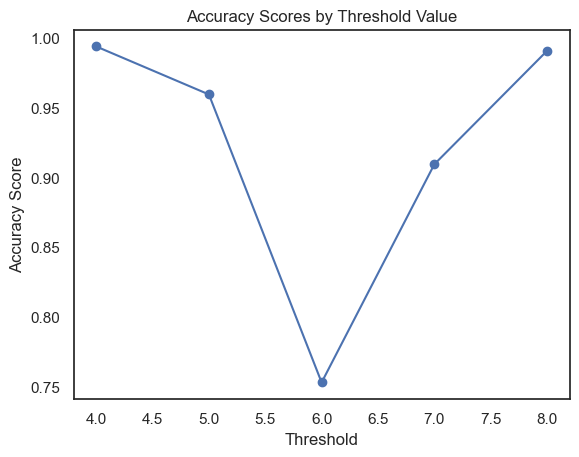

In [17]:
# Initialize a list to store the accuracy scores and threshold values
accuracies = []
thresholds = []
model_num = 4

# Loop through different threshold values, from 4 to 8
for threshold in range(4, 9):
    df_binned = df_imputed
    df_binned['quality_bin'] = (df_imputed['quality'] >= threshold).astype(int)
    df_binned = move_last_to_first(df_binned)

    # Drop the `quality` column, otherwise LGR model will learn this feature
    df_binned = df_binned.drop('quality', axis=1)

    print(f'Threshold value == {threshold}')
    print(df_binned['quality_bin'].value_counts())

    # Evaluate the model on the testing set
    acc, _ = LGR(df_binned, target='quality_bin')
    accuracies.append(acc)
    thresholds.append(threshold)
    
    tracker.send((f"Model {model_num}: Binned Data threshold={threshold} (LGR)", acc))
    model_num += 1
    print('\n')

# Plot the results
plt.scatter(thresholds, accuracies)
plt.plot(thresholds, accuracies)
plt.xlabel('Threshold')
plt.ylabel('Accuracy Score')
plt.title('Accuracy Scores by Threshold Value')
plt.show()

As expected, accuracy is highest when there is a large class imbalance (not a good thing). Accuracy drops when classes are balanced.

A threshold of `6` seems ideal, as classes are evenly balanced and accuracy has improved in comparison to Models 1, 2, and 3.

That said, oenologists and wine connoisseurs might prefer highly specific predictions of quality (as done prior to binarizing), whereas laypersons might be satisfied with less specific predictions (i.e., good versus bad). Thus, it's important to consider users when deciding on whether to bin/binarize the target variable.

In [18]:
# Saving the ideal number of bins into `df_ideal_bins` for later use:
ideal_bins = 6
df_ideal_bins = df_imputed
df_ideal_bins['quality_bin'] = (df_imputed['quality'] >= ideal_bins).astype(int)
df_ideal_bins = move_last_to_first(df_ideal_bins)
df_ideal_bins = df_ideal_bins.drop('quality', axis=1)

### 8. Which of the features are most important in predicting quality?

As coefficients are hard to interpret if features are on different scales, I will opt to use `df_normalized` to weigh the relative importance of each feature.

In [19]:
_, weights = LGR(df_normalized)
display(weights)

,Feature,Coef,Magnitude
1,volatile acidity,1.535762,1.535762
2,citric acid,-0.945180,0.945180
6,total sulfur dioxide,-0.758158,0.758158
8,pH,0.737696,0.737696
9,sulphates,-0.567611,0.567611
10,alcohol,-0.396250,0.396250
7,density,0.381878,0.381878
5,free sulfur dioxide,-0.264553,0.264553
3,residual sugar,-0.173689,0.173689
4,chlorides,0.164700,0.164700


Although the correlation matrix heatmap above had found `alcohol` and `sulphates` to be the most correlated with the target variable, the coefficients of the logistic regression model reveal that `volatile acidity`, `citric acid`, and `total sulfur dioxide` impact the predictions the most in terms of the magnitudes of their coefficients.

## Part 3 - Other Algorithms

### 9. Considering another algorithm

Gradient boosting machine (GBM) might be a good option, as `quality` is categorical and decision trees/random forests/GBMs are good options for predicting categorical target variable(s). Unlike a simple decision tree, GBMs might be less prone to overfitting.

### 10. Model hyper-parameters of this algorithm

- `n_estimators`: Number of trees in the forest. The greater the number of trees, the more accurate the model will be, but this also increases the risk of overfitting.

- `max_depth`: Maximum depth of each tree in the forest. A tree with a larger maximum depth will be able to model more complex relationships in the data, but it also increases the risk of overfitting.

- `min_samples_split`: Minimum number of samples required to split an internal node in the tree. Setting this to a higher value can help prevent overfitting by reducing the size of each tree.

- `learning_rate`: Contribution of each tree in the final prediction. A smaller learning rate means that each tree contributes less, so more trees are needed to achieve the same overall accuracy.

- `loss`: Loss function to optimize.

In [20]:
from sklearn.model_selection import GridSearchCV

def GBM(data: pd.DataFrame, target: str = 'quality') -> float:
    """
    Gradient Boosting Machine (GBM) function to 
    - split data into features and target (`quality`)
    - train GBM classifier
    - make predictions on the test set
    - return accuracy score (float)
    """
    # Split the dataset into features and target
    X = data.drop(target, axis=1)
    y = data[target]

    #convert y values to categorical values
    y_transformed = LabelEncoder().fit_transform(y)

    # Split the dataset into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y_transformed, test_size=0.2, random_state=0)

    # Params deriven by GridSearchCV to test a range of values for each hyper-parameter
    params = {
        'learning_rate': 0.1,   # GridSearchCV: [0.1, 0.05, 0.01]
        'max_depth': 7,         # GridSearchCV: [3, 5, 7]
        'n_estimators': 100     # GridSearchCV: [100, 500, 1000]
    }

    # Train a GBM classifier on the training data
    clf = GradientBoostingClassifier(**params)
    
    clf.fit(X_train, y_train)

    # Make predictions on the test data
    y_pred = clf.predict(X_test)

    # Return the accuracy score
    return accuracy_score(y_test, y_pred)

### 11. Re-running another algorithm with the original, sanitized, normalized, and binned data

In [21]:
# Initialize another instance of the generator function for GBM accuracies
tracker_GBM = accuracy_tracker()
next(tracker_GBM)

tracker_GBM.send(("Model 1: Default Data (GBM)", GBM(df)))
tracker_GBM.send(("Model 2: Sanitized Data (GBM)", GBM(df_imputed)))
tracker_GBM.send(("Model 3: Normalized Data (GBM)", GBM(df_normalized)))
tracker_GBM.send(("Model 3: Binned Data threshold=6 (GBM)", GBM(df_ideal_bins, target='quality_bin')))

,Model Name,Accuracy Score
0,Model 1: Default Data (GBM),0.709375


,Model Name,Accuracy Score
0,Model 1: Default Data (GBM),0.709375
1,Model 2: Sanitized Data (GBM),0.871875


,Model Name,Accuracy Score
0,Model 1: Default Data (GBM),0.709375
1,Model 2: Sanitized Data (GBM),0.871875
2,Model 3: Normalized Data (GBM),0.734375


,Model Name,Accuracy Score
0,Model 1: Default Data (GBM),0.709375
1,Model 2: Sanitized Data (GBM),0.871875
2,Model 3: Normalized Data (GBM),0.734375
3,Model 3: Binned Data threshold=6 (GBM),0.8125


Similarly to LGR models, the sanitized data and binned data of GBM models had the highest accuracies. Surprisingly, the sanitized data had a remarkably higher accuracy than other models.

### 12. Which is more robust?

Across the board, the GBM models performed better than the LGR models in terms of accuracy! This might be because:

- **Non-Linearity**: GBM might capture non-linear relationships better than LGR
- **Feature Interactions**: GBM can captures interactions between features, which LGR cannot do
- **Noise**: GBMs can handle noisy or irrelevant features by assigning lower weights to them
- **Imbalances**: GBMs can handle imbalanced classes better than LGR